# Inverter Based Amplifier

In [681]:
import sympy as sp
import numpy as np
import ltspice
import math
from scipy.signal import TransferFunction, bode
import matplotlib.pyplot as plt
import pandas as pd
import re

## Transfer function

### Architecture:
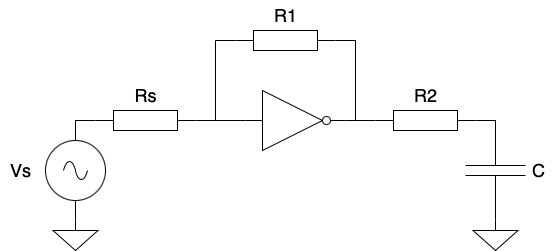

### Using the driving point signal flow graph of this circuit, we find the transfer function easily. For more information about this technique, see: Schmid, Hanspeter, et Alex Huber. « Analysis of Switched-Capacitor Circuits Using Driving-Point Signal-Flow Graphs ». Analog Integrated Circuits and Signal Processing 96, nᵒ 3 (septembre 2018): 495‑507. https://doi.org/10.1007/s10470-018-1131-7.


### Transfer function and signal flow graph

#### Driving Point Signal Flow Graph:

![Capture d’écran 2024-04-08 à 12.21.35.png](<attachment:Capture d’écran 2024-04-08 à 12.21.35.png>)
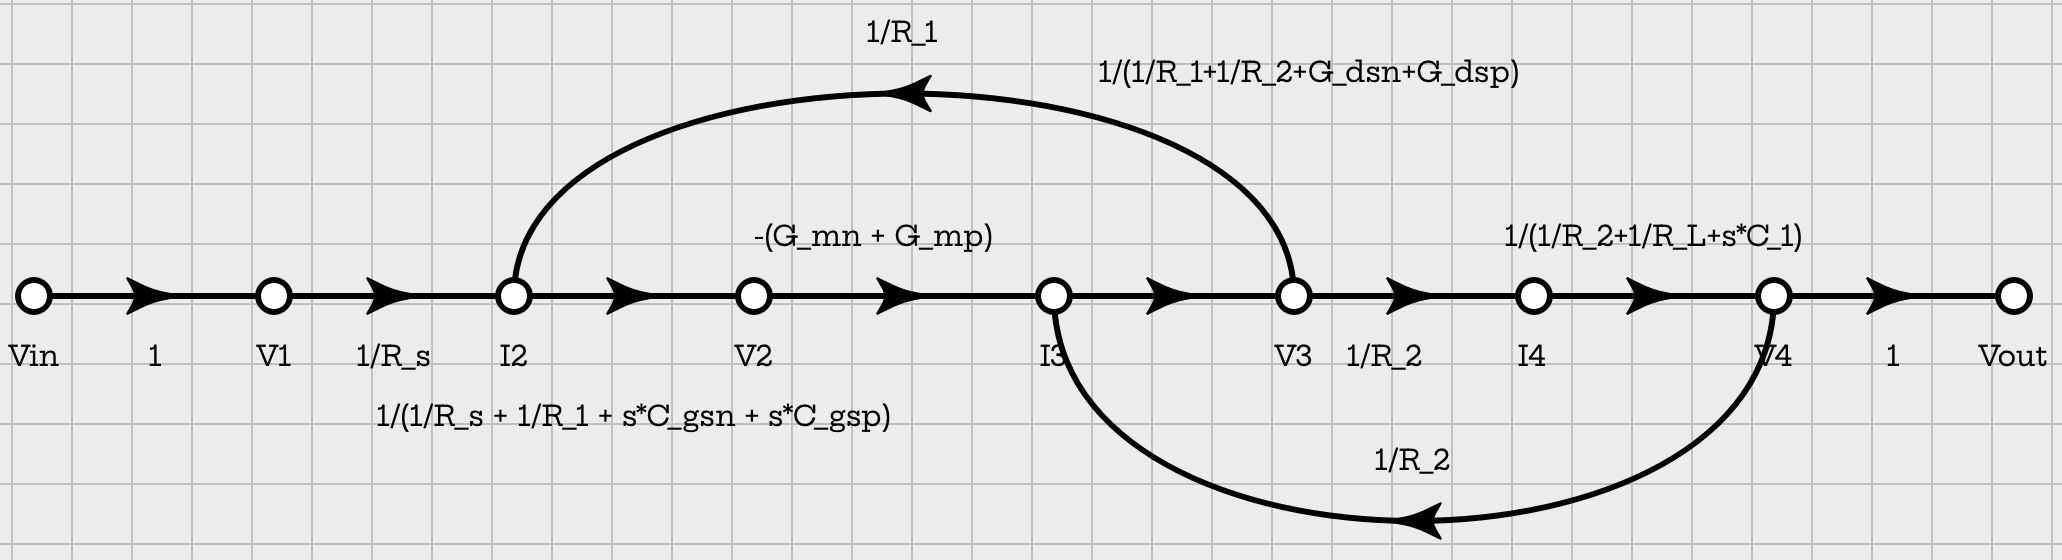

In [682]:
Delta = sp.symbols('Delta')
L1,L2 = sp.symbols('L1,L2')
T_num = sp.symbols('T_num')
T_den = sp.symbols('T_den')
T_io = sp.symbols('T_io')

R_s,G_dsp,C_1,G_mn,R_L,C_gsp,C_gsn,G_dsn,s,G_mp,R_2,R_1 = sp.symbols('R_s,G_dsp,C_1,G_mn,R_L,C_gsp,C_gsn,G_dsn,s,G_mp,R_2,R_1')

loops = [(L1, (-G_mn - G_mp)/(R_1*(G_dsn + G_dsp + 1/R_2 + 1/R_1)*(C_gsn*s + C_gsp*s + 1/R_s + 1/R_1))), (L2, 1/(R_2**2*(C_1*s + 1/R_L + 1/R_2)*(G_dsn + G_dsp + 1/R_2 + 1/R_1)))]
determinant = [(Delta, -L1 - L2 + 1)]
denominator = [(T_den, Delta)]

P1,D1 = sp.symbols('P1,D1')
paths = [(P1, (-G_mn - G_mp)/(R_2*R_s*(C_1*s + 1/R_L + 1/R_2)*(G_dsn + G_dsp + 1/R_2 + 1/R_1)*(C_gsn*s + C_gsp*s + 1/R_s + 1/R_1))), (D1, 1)]
numerator = [(T_num, D1*P1)]

transfer_function = [(T_io, T_num/T_den)]
T=T_io.subs(transfer_function).subs(numerator).subs(denominator).subs(determinant).subs(paths).subs(loops).simplify()

# In our case we consider Rs close to 0 and Rl close to infinit 
T = T.subs(R_s,0).simplify()
T = T.limit(R_L, sp.oo).simplify()

print("The transfer function is: ")
display(T)

The transfer function is: 


-R_1*(G_mn + G_mp)/(C_1*G_dsn*R_1*R_2*s + C_1*G_dsp*R_1*R_2*s + C_1*R_1*s + C_1*R_2*s + G_dsn*R_1 + G_dsp*R_1 + 1)

In [683]:
gain_formula = T.subs(s,0)
print("The gain function is: ")
display(gain_formula)
print("==> To achieve higher gain we should maximize R1*(gmn+gmp)")

The gain function is: 


-R_1*(G_mn + G_mp)/(G_dsn*R_1 + G_dsp*R_1 + 1)

==> To achieve higher gain we should maximize R1*(gmn+gmp)


In [684]:
Delta = sp.symbols('Delta')
L1,L2 = sp.symbols('L1,L2')
T_num = sp.symbols('T_num')
T_den = sp.symbols('T_den')
T_io = sp.symbols('T_io')
C_gsp,G_mn,C_1,G_dsp,R_1,R_L,s,G_mp,G_dsn,C_gsn,R_2,R_s = sp.symbols('C_gsp,G_mn,C_1,G_dsp,R_1,R_L,s,G_mp,G_dsn,C_gsn,R_2,R_s')

loops = [(L1, (-G_mn - G_mp)/(R_1*(G_dsn + G_dsp + 1/R_2 + 1/R_1)*(C_gsn*s + C_gsp*s + 1/R_s + 1/R_1))), (L2, 1/(R_2**2*(C_1*s + 1/R_L + 1/R_2)*(G_dsn + G_dsp + 1/R_2 + 1/R_1)))]
determinant = [(Delta, -L1 - L2 + 1)]
denominator = [(T_den, Delta)]

P1,D1 = sp.symbols('P1,D1')
paths = [(P1, 1/(R_2*(C_1*s + 1/R_L + 1/R_2)*(G_dsn + G_dsp + 1/R_2 + 1/R_1))), (D1, 1)]
numerator = [(T_num, D1*P1)]

transfer_function = [(T_io, T_num/T_den)]
T_noise=T_io.subs(transfer_function).subs(numerator).subs(denominator).subs(determinant).subs(paths).subs(loops).simplify()
T_noise = T_noise.subs(R_s,0).simplify()
T_noise = T_noise.limit(R_L, sp.oo).simplify()
T_noise_max = T_noise.subs(s,0)
display(T_noise_max)
display(T_noise)

R_1/(G_dsn*R_1 + G_dsp*R_1 + 1)

R_1/(C_1*G_dsn*R_1*R_2*s + C_1*G_dsp*R_1*R_2*s + C_1*R_1*s + C_1*R_2*s + G_dsn*R_1 + G_dsp*R_1 + 1)

## Simulation

### Values of parameters

In [685]:
# Conditions to store simulation if usefull 
store_sim = False

In [686]:
# Arrays to store the results of the simulations
op = np.zeros(6)    # order: G_mn, G_mp, G_dsn, G_dsp, C_gsn, C_gsp
param_values = np.zeros(16)    # order: Vdd, Wn, Ln, Wp, Lp, Wr1, Lr1, R_1, Wr2, Lr2, R_2, Wc, Lc, MFc, C_1, Vdc
results_calc = np.zeros(4)    # order: gain (in dB), cut-off, noise, power
results_sim = np.zeros(4)    # order: gain (in dB), cut-off, noise, power

def extract_spice_params(file_path):
    # Parameters to extract
    params = {
        'Vdd': None,
        'Wn': None,
        'Ln': None,
        'Wp': None,
        'Lp': None,
        'Wr1': None,
        'Lr1': None,
        'R_1': None,
        'Wr2': None,
        'Lr2': None,
        'R_2': None,
        'Wc': None,
        'Lc': None,
        'MFc': None,
        'C_1': None,
        'Vdc': None
    }
    
    # Open and read the SPICE file
    with open(file_path, 'r') as file:
        content = file.readlines()
    
    # Regex patterns to capture values
    patterns = {
        'Vdd': r'VP VCC GND (\d+\.?\d*)',
        'Vdc': r'Vin in GND (\d+\.?\d*) ac',
        'Wn': r'x1 test in VCC VSS not W_N=(\d+) L_N=',  # Adjusted to target the specific line
        'Ln': r'x1 test in VCC VSS not .*L_N=(\d+\.?\d*) W_P=',  # Adjusted to target the specific line
        'Wp': r'x1 test in VCC VSS not .*W_P=(\d+)',
        'Lp': r'x1 test in VCC VSS not .*L_P=(\d+\.?\d*) m=',  # Adjusted to target the specific line
        'Wr1': r'XR1 .+ W=(\d+) L=',
        'Lr1': r'XR1 .+ L=(\d+) mult=',
        'R_1': r'XR1 .+ mult=(\d+)',
        'Wr2': r'XR2 .+ W=(\d+) L=',
        'Lr2': r'XR2 .+ L=(\d+) mult=',
        'R_2': r'XR2 .+ mult=(\d+)',
        'Wc': r'XC1 .+ W=(\d+) L=',
        'Lc': r'XC1 .+ L=(\d+)',
        'MFc': r'MF=(\d+) m='
    }
    
    # Extract parameters
    for line in content:
        for key, pattern in patterns.items():
            match = re.search(pattern, line)
            if match:
                params[key] = float(match.group(1))
    
    # Calculate capacitance using the given formula
    if params['Wc'] and params['Lc'] and params['MFc']:
        params['C_1'] = params['MFc'] * params['Wc'] * params['Lc']  # Simple multiplication

    # Convert to NumPy array
    param_values = np.array([params[key] for key in params], dtype=float)
    
    return param_values

# Usage
file_path = "../netlist/tb_inv_sky130_a.spice"
param_values = extract_spice_params(file_path)
print("The values of the parameters are: ")
print("Vdd = ", param_values[0])
print("Wn = ", param_values[1])
print("Ln = ", param_values[2])
print("Wp = ", param_values[3])
print("Lp = ", param_values[4])
print("Wr1 = ", param_values[5])
print("Lr1 = ", param_values[6])
param_values[7] = 2e3*param_values[6]/param_values[5]
print("R_1 = ", param_values[7])
print("Wr2 = ", param_values[8])
print("Lr2 = ", param_values[9])
param_values[10] = 2e3*param_values[9]/param_values[8]
print("R_2 = ", param_values[10])
print("Wc = ", param_values[11])
print("Lc = ", param_values[12])
print("MFc = ", param_values[13])
param_values[14] = param_values[13] * (param_values[11] * param_values[12] * 2e-15 + (param_values[11] + param_values[12]) * 0.38e-15)
print("C_1 = ", param_values[14])
print("Vdc = ", param_values[15])


The values of the parameters are: 
Vdd =  1.125
Wn =  250.0
Ln =  1.0
Wp =  200.0
Lp =  0.25
Wr1 =  1.0
Lr1 =  90.0
R_1 =  180000.0
Wr2 =  1.0
Lr2 =  50.0
R_2 =  100000.0
Wc =  55.0
Lc =  55.0
MFc =  5.0
C_1 =  3.0459e-11
Vdc =  0.44866


### Results

####  Operating point

In [687]:
filepath = '../netlist/tb_inv_sky130_a_op.raw'  # Update to your file's path

# Load the LTSpice file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Get the data by specifying the trace name
gmn = lt.get_data('gmn')
gmp = lt.get_data('gmp')
gdsn = lt.get_data('gdsn')
gdsp = lt.get_data('gdsp')
cgsn = lt.get_data('cgsn')
cgsp = lt.get_data('cgsp')

# Create numpy array
#The values are stored in the following order: G_mn, G_mp, G_dsn, G_dsp, C_gsn, C_gsp
op = np.array([gmn, gmp, gdsn, gdsp, abs(cgsn), abs(cgsp)]).flatten()
print("The operating point values are:")
print("gmn = ", op[0])
print("gmp = ", op[1])
print("gdsn = ", op[2])
print("gdsp = ", op[3])
print("cgsn = ", op[4])
print("cgsp = ", op[5])

[Warning] Variable data type is detected as double precision.
The operating point values are:
gmn =  6.949360024383546e-05
gmp =  5.0065060301136266e-05
gdsn =  5.28412053626838e-07
gdsp =  1.5860315441138129e-06
cgsn =  6.107786125829054e-13
cgsp =  6.14051741607894e-14


#### Noise

In [688]:
filepath = '../netlist/tb_inv_sky130_a_noise.raw'  # Update to your file's path

# Load the LTSpice file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Get the data by specifying the trace name
inoise = lt.get_data('v(inoise_total)')[0]*1e6  # Convert to uV
RL_noise = lt.get_data('v(inoise_total_rl)')[0]*1e6
R1_noise_1 = lt.get_data('v(inoise_total_r.x1.xr1.rend1)')[0]*1e6
R1_noise_2 = lt.get_data('v(inoise_total_r.x1.xr1.rend2)')[0]*1e6
R1_noise = R1_noise_1 + R1_noise_2
R2_noise_1 = lt.get_data('v(inoise_total_r.x1.xr2.rend1)')[0]*1e6
R2_noise_2 = lt.get_data('v(inoise_total_r.x1.xr2.rend2)')[0]*1e6
R2_noise = R2_noise_1 + R2_noise_2
nfet_noise = lt.get_data('v(inoise_total.m.x1.x1.xm1.msky130_fd_pr__nfet_01v8)')[0]*1e6
nfet_noise_1ovf = lt.get_data('v(inoise_total.m.x1.x1.xm1.msky130_fd_pr__nfet_01v8.1overf)')[0]*1e6
pfet_noise = lt.get_data('v(inoise_total.m.x1.x1.xm2.msky130_fd_pr__pfet_01v8)')[0]*1e6
pfet_noise_1ovf = lt.get_data('v(inoise_total.m.x1.x1.xm2.msky130_fd_pr__pfet_01v8.1overf)')[0]*1e6

print("The noise values are:")
print(f"inoise total = {inoise} uV")
print(f"inoise total RL = {RL_noise} uV")
print(f"inoise total R1 = {R1_noise} uV")
print(f"inoise total R2 = {R2_noise} uV")
print(f"inoise total nfet = {nfet_noise} uV")
print(f"inoise total nfet Flicker = {nfet_noise_1ovf} uV")
print(f"inoise total pfet = {pfet_noise} uV")
print(f"inoise total pfet Flicker = {pfet_noise_1ovf} uV")

[Warning] Variable data type is detected as double precision.
The noise values are:
inoise total = 2.832481347720852 uV
inoise total RL = 6.24437722086131e-06 uV
inoise total R1 = 0.010402197035950234 uV
inoise total R2 = 0.014595408309241838 uV
inoise total nfet = 2.5340598443914075 uV
inoise total nfet Flicker = 2.294467303886347 uV
inoise total pfet = 1.2654369499770022 uV
inoise total pfet Flicker = 1.1276311602288134 uV


[Warning] Variable data type is detected as double precision.


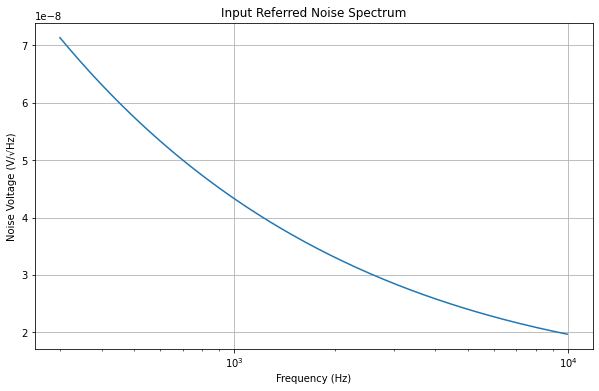

In [689]:
# Specify the path to your .raw file
filepath = '../netlist/tb_inv_sky130_a_noise_spectrum.raw'

# Load the LTSpice raw file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Fetch frequency and inoise data
frequency = lt.get_frequency()  # Frequency data
inoise_spectrum = lt.get_data('inoise_spectrum')  # Total input-referred noise

plt.figure(figsize=(10, 6))
plt.semilogx(frequency, inoise_spectrum)
plt.title('Input Referred Noise Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Noise Voltage (V/√Hz)')
plt.grid(True)
plt.show()

#### DC analysis

[Warning] Variable data type is detected as double precision.


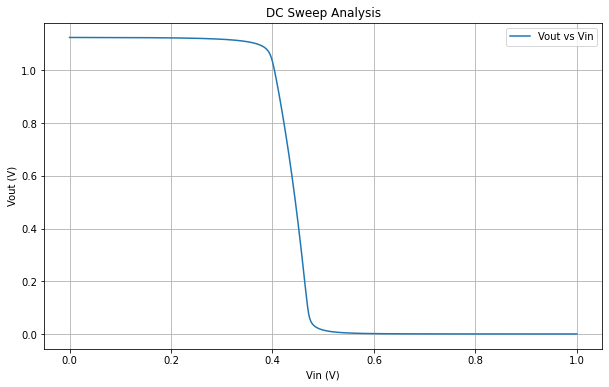

In [690]:
filepath = '../netlist/tb_inv_sky130_a_DC.raw'

# Load the LTSpice raw file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Get the data
time = lt.get_time()
vin = lt.get_data('V(in)')
vout = lt.get_data('V(out)')

plt.figure(figsize=(10, 6))
plt.plot(vin, vout, label='Vout vs Vin')
plt.title('DC Sweep Analysis')
plt.xlabel('Vin (V)')
plt.ylabel('Vout (V)')
plt.grid(True)
plt.legend()
plt.show()

In [691]:
differences = np.abs(vin - vout)
op_point = np.argmin(differences)/1e2    # in mV
print(f"The DC operating point is: {op_point} mV")

The DC operating point is: 448.66 mV


#### AC analysis

/Users/miguelcorrea/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/miguelcorrea/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


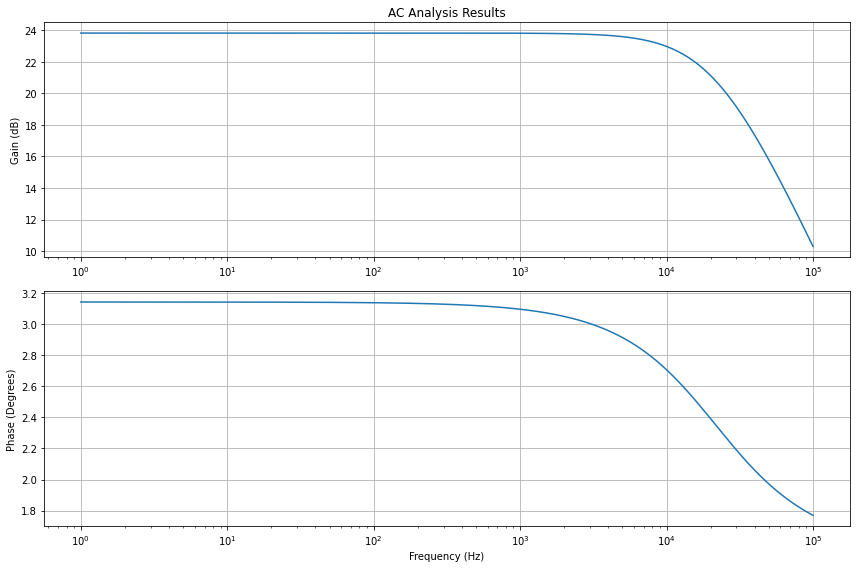

In [692]:
filepath = '../netlist/tb_inv_sky130_a_AC.raw' 

# Load the LTSpice raw file
lt = ltspice.Ltspice(filepath) 
lt.parse()

# Get frequency, gain, and phase data
frequency = lt.get_frequency()
gain_sim = lt.get_data('gain')  # Make sure the label matches what's in the .raw file
phase = lt.get_data('phase')  # Make sure the label matches what's in the .raw file

plt.figure(figsize=(12, 8))

# Plot gain
plt.subplot(2, 1, 1)
plt.semilogx(frequency, gain_sim)
plt.title('AC Analysis Results')
plt.ylabel('Gain (dB)')
plt.grid(True)

# Plot phase
plt.subplot(2, 1, 2)
plt.semilogx(frequency, phase)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (Degrees)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [693]:
max_gain_sim = np.max(gain_sim)
cutoff_index = np.argmin(np.abs(gain_sim - (max_gain_sim - 3)))
cutoff_frequency_sim = frequency[cutoff_index]/1e3        # Convert to kHz

print(f"Maximum Gain: {abs(max_gain_sim)} dB")
print(f"Cutoff Frequency: {cutoff_frequency_sim} kHz")

Maximum Gain: 23.82489251230438 dB
Cutoff Frequency: 21.51295159281681 kHz


#### Power (and trans simulation)

[Warning] Variable data type is detected as double precision.


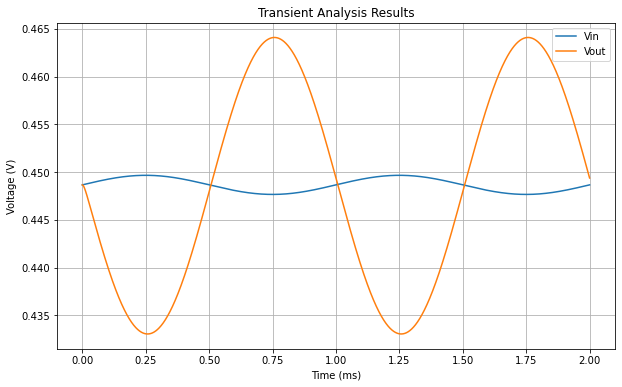

In [694]:
filepath = '../netlist/tb_inv_sky130_a_tran.raw'  # Update to your .raw file path

# Load the LTSpice raw file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Get the time and voltage data
time = lt.get_time()
v_in = lt.get_data('V(in)')
v_out = lt.get_data('V(out)')

# Plot the voltages
plt.figure(figsize=(10, 6))
plt.plot(time * 1e3, v_in, label='Vin')
plt.plot(time * 1e3, v_out, label='Vout')
plt.title('Transient Analysis Results')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.show()

In [695]:
avg_pw_total = lt.get_data('avg_pw_total')[0]*1e6  # Convert to uW
print(f"The average power is: {abs(avg_pw_total)} uW")

The average power is: 2.794644 uW


#### Results of simulation summary

In [696]:
# Here I will store my real simulation outputs
# order: gain (in dB), cut-off, noise, power
results_sim = np.array([abs(max_gain_sim), abs(cutoff_frequency_sim), abs(inoise), abs(avg_pw_total)])
print("The results of the simulation are: ")
print(f"Gain = {results_sim[0]} dB")
print(f"Cut-off = {results_sim[1]} kHz")
print(f"Noise = {results_sim[2]} uV")
print(f"Power = {results_sim[3]} uW")

The results of the simulation are: 
Gain = 23.82489251230438 dB
Cut-off = 21.51295159281681 kHz
Noise = 2.832481347720852 uV
Power = 2.794644 uW


## Calculations (to help design choices)

#### R1 for 20dB

In [697]:
gain = gain_formula.subs([(G_mn, op[0]), (G_mp, op[1]), (G_dsn, op[2]), 
                          (G_dsp, op[3]), (C_gsn, op[4]), (C_gsp, op[5])])

R1_solution = sp.solve(gain + 10, R_1)

# Display the result
print("The value of R1 to achieve a gain of 20 dB is: ", R1_solution[0])

The value of R1 to achieve a gain of 20 dB is:  101611.327467551


#### C1 for 500kHz

In [698]:
T_den = sp.denom(T).simplify()
cutoff_frequency = 20e3

# Update the expression with values in op and R1
T_den = T_den.subs([(G_mn, op[0]), (G_mp, op[1]), (G_dsn, op[2]), 
                    (G_dsp, op[3]), (C_gsn, op[4]), (C_gsp, op[5]),
                    (R_1, param_values[7])])
T_den_sim = T_den
# Update the expression with the new value of s (2*pi*f)
T_den = T_den.subs(s, 2*sp.pi*cutoff_frequency) 

#choosing a value for C1 by solving the denominator
R2 = param_values[10]
C1_perf = sp.solve(T_den, C_1)
print("The value of C1 to have a cut-off frequency of 20kHz is: ")
display(C1_perf[0])
print("==> A bigger R2 will decrease the value of C1")

C1_perf = C1_perf[0].subs(R_2, R2)
print("The value of C1 to have a cut-off frequency of 20kHz with our R2 is around: ", C1_perf)


The value of C1 to have a cut-off frequency of 20kHz is: 


-1464861934.50929/(184079979679109.0*R_2 + 2.4e+19)

==> A bigger R2 will decrease the value of C1
The value of C1 to have a cut-off frequency of 20kHz with our R2 is around:  -3.45421148062146e-11


#### Gain and cut-off frequency

In [699]:
T_num = T.subs([(G_mn, op[0]), (G_mp, op[1]), (G_dsn, op[2]), 
                (G_dsp, op[3]), (C_gsn, op[4]), (C_gsp, op[5]),
                (R_1, param_values[7]), (R_2, param_values[10]),
                (C_1, param_values[14])])

# Replace this example with your actual transfer function
num, den = sp.fraction(T_num)  # T is your transfer function in symbolic form
num_coeffs = [float(c) for c in sp.Poly(num, s).all_coeffs()]
den_coeffs = [float(c) for c in sp.Poly(den, s).all_coeffs()]

sys = TransferFunction(num_coeffs, den_coeffs)

w, mag, phase = bode(sys)

# Convert magnitude in dB to numpy array
mag_array = np.array(mag)

# Find index where magnitude is closest to -3 dB
index = np.argmin(np.abs(mag_array - (mag_array[0]-3)))
cutoff_frequency = w[index] / (2 * np.pi)  # Convert from rad/s to Hz

print(f"The gain is approximately {mag_array[0]:.2f} Hz")
print(f"The cutoff frequency is approximately {cutoff_frequency:.2f} Hz")


The gain is approximately 23.83 Hz
The cutoff frequency is approximately 22559.80 Hz


## Other simulation results

In [700]:
if store_sim == True:
    with open('param_values.txt', 'ab') as f:  # 
        np.savetxt(f, param_values, fmt='%e', delimiter=',')
    with open('results_sim.txt', 'ab') as f:  # 
        np.savetxt(f, results_sim, fmt='%e', delimiter=',')

In [701]:
# Load data from text files
loaded_param_values = np.loadtxt('param_values.txt', delimiter=',')
loaded_results_sim = np.loadtxt('results_sim.txt', delimiter=',')

# Calculate the number of simulations based on the expected structure
num_simulations_params = loaded_param_values.size // 16  # Assuming 8 parameters per simulation
num_simulations_sim = loaded_results_sim.size // 4     # Assuming 4 simulated results per simulation

# Reshape arrays to match the number of simulations and parameters
loaded_param_values = loaded_param_values.reshape(num_simulations_params, 16)
loaded_results_sim = loaded_results_sim.reshape(num_simulations_sim, 4)


# Create DataFrames from the reshaped arrays
# order: Vdd, Wn, Ln, Wp, Lp, Wr1, Lr1, R_1, Wr2, Lr2, R_2, Wc, Lc, MFc, C_1, Vdc
df_parameters = pd.DataFrame(loaded_param_values, columns=['Vdd', 'Wn', 'Ln', 'Wp', 'Lp', 'Wr1', 'Lr1', 'R1 (in kOhms)',
                                                            'Wr2', 'Lr2', 'R2 (in kOhms)', 'Wc', 'Lc', 'MFc', 'C1 (in pF)', 'Vdc (in mV)'])

df_simulated_results = pd.DataFrame(loaded_results_sim, columns=['gain (in dB)', 'cut-off frequency (in kHz)', 'noise in (uV)', 'power (in uW)'])

df_complete_simulation_results = pd.concat([df_parameters, df_simulated_results], axis=1)

df_complete_simulation_results['R1 (in kOhms)'] = df_complete_simulation_results['R1 (in kOhms)'] / 1000
df_complete_simulation_results['R2 (in kOhms)'] = df_complete_simulation_results['R2 (in kOhms)'] / 1000
df_complete_simulation_results['C1 (in pF)'] = df_complete_simulation_results['C1 (in pF)'] * 1e12
df_complete_simulation_results['Vdc (in mV)'] = df_complete_simulation_results['Vdc (in mV)'] * 1e3

df_complete_simulation_results.to_csv('complete_simulation_results.csv', index=False)

df_complete_simulation_results

,Vdd,Wn,Ln,Wp,Lp,Wr1,Lr1,R1 (in kOhms),Wr2,Lr2,R2 (in kOhms),Wc,Lc,MFc,C1 (in pF),Vdc (in mV),gain (in dB),cut-off frequency (in kHz),noise in (uV),power (in uW)
0,1.500,20.0,0.15,40.0,0.15,1.0,30.0,60.0,1.0,50.0,100.0,15.0,15.0,6.0,2.7680,705.20,20.51506,525.04920,15.436560,161.388100
1,1.250,40.0,0.15,80.0,0.15,1.0,50.0,100.0,1.0,50.0,100.0,15.0,15.0,6.0,2.7680,590.10,20.22268,489.27210,9.761662,30.489360
2,1.125,50.0,0.15,100.0,0.15,1.0,90.0,180.0,1.0,50.0,100.0,14.0,13.0,6.0,2.2460,538.00,20.17452,519.93700,8.460034,9.831864
3,1.125,50.0,0.15,100.0,0.15,1.0,90.0,180.0,1.0,50.0,100.0,70.0,60.0,6.0,50.7000,538.00,20.17452,23.02707,8.460322,9.831872
4,1.125,250.0,1.00,200.0,0.25,1.0,90.0,180.0,1.0,50.0,100.0,70.0,60.0,6.0,50.6964,448.66,23.82489,12.94196,2.832653,2.794655
5,1.125,250.0,1.00,200.0,0.25,1.0,90.0,180.0,1.0,50.0,100.0,55.0,55.0,5.0,30.4590,448.66,23.82489,21.51295,2.832481,2.794644
